# GMR VS GPR

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import csv

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA

from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 0 Loading and preprocessing dataset

In [13]:
#Use diagnostic dataset, change to false for prognostic
diagnosticSet = False #prognostic is recommended for regression
csvDelimiter = ','

def load_parse_data():
    
    if diagnosticSet:
        fileName='wdbc' #diagnostic
    else :
        fileName='wpbc' #prognostic- Outcome column: N=0, R=1 !
    datapath = os.path.join('../dataset', fileName+'_data.csv')
    headerpath = os.path.join('../dataset', fileName+'_header.csv')
    
    data = list(csv.reader(open(datapath), delimiter=csvDelimiter))
    header = list(csv.reader(open(headerpath), delimiter=csvDelimiter))
    
    data = pd.DataFrame(data, columns=header[0])
    
    return data, header[0]

#REMOVE NAN numbers

data, headers = load_parse_data()
print(headers) #refer to w*bc_names.txt for details (7. Attribute information)
#tu peux accéder aux colonnes avec leurs en-têtes, 3 cellules donc 3 textures
#print("textures of all 3 cells:")
print(data.Compactness)



['ID', 'Outcome', 'Time', 'CellRadius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePts', 'Symmetry', 'FractalDim', 'CellRadius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePts', 'Symmetry', 'FractalDim', 'CellRadius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePts', 'Symmetry', 'FractalDim', 'TumorSize', 'LymphNode']
    Compactness Compactness Compactness
0        0.1036     0.01421      0.1926
1        0.2776     0.04904      0.6656
2        0.1189     0.03449      0.3449
3        0.2839     0.07458      0.8663
4        0.1328     0.02461       0.205
5        0.1569     0.02987      0.4196
6        0.1237     0.02354      0.3371
7        0.1645     0.03029      0.3682
8        0.1932     0.03502      0.5401
9        0.2396     0.07217       1.058
10      0.06669    0.009269      0.1551
11       0.1292     0.04061      0.5609
12       0.1002     0.03126      0.1924
13  

In [14]:
ratioTrainTest = 0.6
ratioDataset = 1 # percentage of dataset used

x_train,x_test=train_test_split(data,train_size=ratioTrainTest*ratioDataset,\
                                test_size=(1-ratioTrainTest)*ratioDataset,\
                                random_state=0)

# 1 GMR

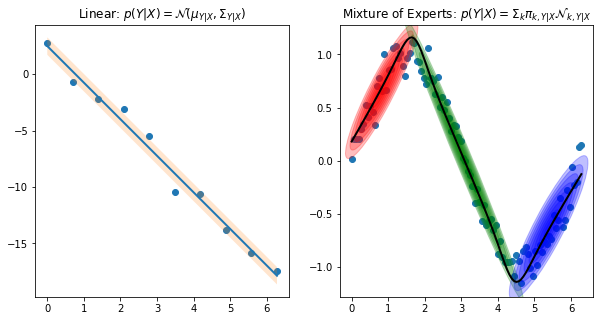

In [16]:
random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = covariance.ravel()
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()


2. GPR 

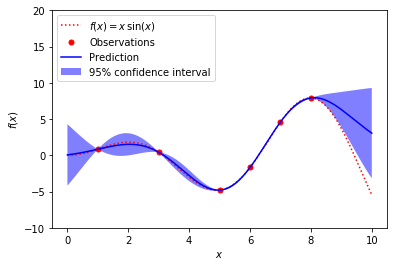

In [17]:
np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')